In [41]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt

In [42]:
data_import = pd.read_csv('/Users/sitanshurupani/Data Science Coursework/Sem 4/GQP - National Parks/DataSpell Project/Data/Daily_attendance.csv')

In [43]:
all_years_test = data_import
all_years_test.set_index('Full_Date', inplace=True)

In [44]:
all_years_test.index = pd.to_datetime(all_years_test.index)
ds = all_years_test.index.to_series()
all_years_test['YEAR'] = ds.dt.year
all_years_test['MONTH'] = ds.dt.month
all_years_test['DAY_OF_WEEK'] = ds.dt.dayofweek
all_years_test['DAY'] = ds.dt.day

In [45]:
all_years_test.drop(columns=['snow_1h', 'temp_max', 'temp_min','YEAR', 'wind_gust', 'pressure'], inplace=True)
all_years_test["federal_holiday_flag"] = all_years_test["federal_holiday_flag"].astype(int)
all_years_test["school_holiday_flag"] = all_years_test["school_holiday_flag"].astype(int)

In [46]:
all_years_test.isna().sum()

value                   0
temp                    0
humidity                0
wind_speed              0
rain_1h                 0
federal_holiday_flag    0
school_holiday_flag     0
MONTH                   0
DAY_OF_WEEK             0
DAY                     0
dtype: int64

In [47]:
df_2021 = all_years_test[all_years_test.index.year==2021]

In [48]:
mask = np.random.rand(len(df_2021)) < 0.8
df_train = df_2021[mask]
df_test = df_2021[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=147
Testing data set length=37


In [49]:
expr = """value ~ DAY  + DAY_OF_WEEK + MONTH + temp + humidity + wind_speed + rain_1h + federal_holiday_flag + school_holiday_flag"""

In [50]:
# X_train, X_test, y_train, y_test = train_test_split(all_years_test.loc[:, all_years_test.columns != 'value'], all_years_test['value'], test_size =0.2, random_state = 42)

In [51]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [52]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [53]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  value   No. Observations:                  147
Model:                            GLM   Df Residuals:                      137
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4643.2
Date:                Tue, 19 Apr 2022   Deviance:                       7989.7
Time:                        15:11:31   Pearson chi2:                 7.89e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.2365 

In [54]:
print(poisson_training_results.mu)

[ 724.26337236  876.69477476  654.907994    659.4224344   820.6149404
  909.48668284  756.36853753  873.82776109  958.47219824  945.64426321
  860.34541583  851.79122384 1025.82205529  823.38651704  818.54756467
  815.73467623  898.32329141  932.06927332  831.14261888  901.88871494
 1016.64561811  864.20112709  841.09043397  746.05293923  911.60053894
 1064.98859146  913.53291337  892.04434964 1017.3712177  1133.9115923
 1112.99005998 1120.4988141   916.77823896 1347.36550246 1030.68173242
 1014.0316275  1147.02178981 1003.49624036  898.47640583 1117.38601143
 1265.90320884 1088.43981709 1234.71118602 1050.96715733 1064.0755298
 1174.51643933 1055.199808   1221.88540714 1118.14706493  963.8831242
 1021.41556266  859.11035471 1154.57195977 1018.35977713 1239.96458602
  824.76740683 1133.05779088 1116.71397671 1091.47962931 1094.62329599
 1135.08897236 1237.38969991 1056.25233362 1060.0959775  1129.27107736
 1149.45566014 1207.0611202  1301.3192312  1155.28991093 1120.25370759
 1330.5751

In [55]:
mu_glm = poisson_training_results.mu

In [56]:
df_train['Value_LAMBDA'] = mu_glm

/var/folders/90/98s1yvbs2zq9h146qcbc3t_h0000gn/T/ipykernel_68352/2113704252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['Value_LAMBDA'] = mu_glm


In [57]:
df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['value'] - x['Value_LAMBDA'])**2 - x['Value_LAMBDA']) / x['Value_LAMBDA'], axis=1)

/var/folders/90/98s1yvbs2zq9h146qcbc3t_h0000gn/T/ipykernel_68352/1666380816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['AUX_OLS_DEP'] = df_train.apply(lambda x: ((x['value'] - x['Value_LAMBDA'])**2 - x['Value_LAMBDA']) / x['Value_LAMBDA'], axis=1)


In [58]:
ols_expr = """AUX_OLS_DEP ~ Value_LAMBDA - 1"""

In [59]:
aux_olsr_results = smf.ols(ols_expr, df_train).fit()

In [60]:
print(aux_olsr_results.params)

Value_LAMBDA    0.044177
dtype: float64


In [61]:
aux_olsr_results.tvalues

Value_LAMBDA    6.236349
dtype: float64

In [62]:
nb2_training_results = sm.GLM(y_train, X_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

In [63]:
print(nb2_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  value   No. Observations:                  147
Model:                            GLM   Df Residuals:                      137
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1025.1
Date:                Tue, 19 Apr 2022   Deviance:                       181.58
Time:                        15:11:38   Pearson chi2:                     168.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.1581 

In [64]:
nb2_predictions = nb2_training_results.get_prediction(X_test)

In [65]:
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

                   mean     mean_se  mean_ci_lower  mean_ci_upper
Full_Date                                                        
2021-05-03   900.881307   73.740569     767.349977    1057.649252
2021-05-04   782.553972   50.771177     689.111265     888.667405
2021-05-08   712.127162   41.038985     636.068496     797.280635
2021-05-10   741.990080   43.537644     661.381846     832.422724
2021-05-11   677.780364   40.301050     603.220720     761.555773
2021-05-17   783.330322   45.147738     699.657347     877.009861
2021-05-28  1136.284991   86.838714     978.217866    1319.893682
2021-06-18  1213.740367   45.148278    1128.400077    1305.534897
2021-06-22   984.361858   52.926076     885.907375    1093.757987
2021-06-25   971.199149   49.217688     879.370216    1072.617393
2021-06-27  1116.967766  134.667752     881.891425    1414.705887
2021-06-28  1099.142632  113.755627     897.344194    1346.322329
2021-06-29  1248.638999   83.636662    1095.018590    1423.810851
2021-07-07

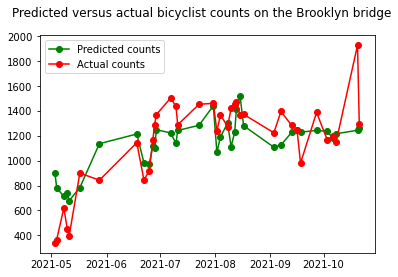

In [66]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()

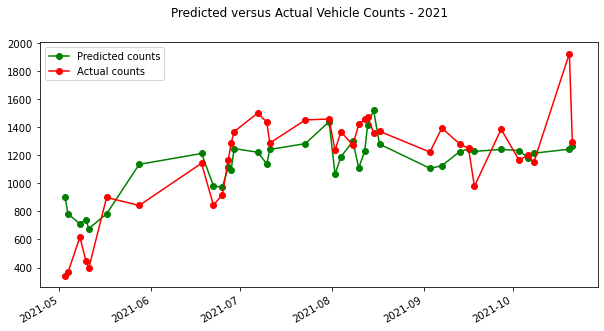

In [67]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
fig = plt.figure(figsize=(10,5))
fig.suptitle('Predicted versus Actual Vehicle Counts - 2021')
predicted, = plt.plot(predicted_counts.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts.index, actual_counts, 'ro-', label='Actual counts')
fig.autofmt_xdate()
plt.legend(handles=[predicted, actual])
plt.show()

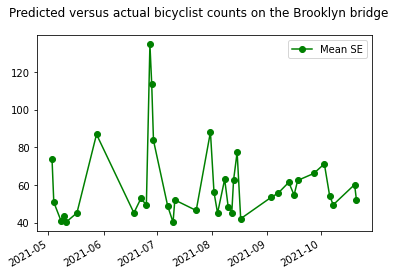

In [68]:
predicted_mean_se=predictions_summary_frame['mean_se']
predicted_mean_se = predicted_mean_se[predicted_mean_se.index.year==2021]
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(predicted_mean_se.index, predicted_mean_se, 'go-', label='Mean SE')
fig.autofmt_xdate()
plt.legend(handles=[predicted])
plt.show()

In [69]:
from statsmodels.tools.eval_measures import rmse
rmse(y_test, predictions_summary_frame['mean'])

array([440.09145401, 519.19163394, 572.72657058, 549.5611906 ,
       600.10244551, 518.62399157, 354.955432  , 357.70761035,
       396.22488987, 402.30966664, 356.89434484, 359.59594801,
       364.36171829, 359.07774425, 354.79392545, 362.9330759 ,
       374.33882597, 450.49381432, 366.75369698, 355.02177739,
       380.42991008, 357.73080153, 360.48577526, 436.54357293,
       505.31007867, 373.20074906, 358.1342383 , 355.87456881,
       359.85414401, 363.69312155, 360.18709837, 363.00873819,
       361.30662005, 354.64494448, 358.01564763, 363.37345477,
       368.22486473])

<Figure size 432x288 with 0 Axes>

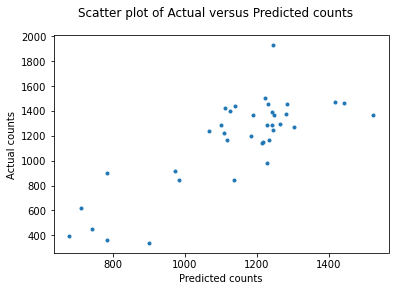

In [70]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['value']
plt.clf()
fig = plt.figure()
fig.suptitle('Scatter plot of Actual versus Predicted counts')
plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
plt.xlabel('Predicted counts')
plt.ylabel('Actual counts')
plt.show()

In [71]:
from sklearn.metrics import mean_poisson_deviance, mean_squared_error
from math import sqrt
mean_poisson_deviance(y_test, predictions_summary_frame['mean'])

54.59555037452469

In [72]:
sqrt(mean_squared_error(y_test, predictions_summary_frame['mean']))

228.7160787232443

In [82]:
df_2019 = all_years_test[all_years_test.index.year==2019]
df_2019.drop(columns=['value'],inplace=True)
# df_2019['Intercept'] = 1.0
df_2019= sm.add_constant(df_2019)

/Library/anaconda3/envs/ds_env/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [85]:
y_out_of_sample_pred = nb2_training_results.predict(df_2019)
y_out_of_sample_pred.index = df_2019.index